In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video
import tempfile
import os
import shutil
import glob
import tqdm
import pandas as pd
import pyart
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif
from scipy.ndimage import gaussian_filter
from skimage.measure import regionprops
from load_radar import load_radar
import datetime as dt
from pymeso import llsd
def dealiase(radar, vel_name):
    #check to see if radar object has nyquist velocity
    try: 
        gatefilter = pyart.correct.GateFilter(radar)
        corr_vel   = pyart.correct.dealias_region_based(
            radar, vel_field=vel_name, keep_original=False, gatefilter = gatefilter)
        radar.add_field(vel_name, corr_vel, True)
    except:
        None


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
files = np.sort(glob.glob("/g/data/eg3/ab4502/radar/02_20200131_05*.pvol.h5"))
#files=np.sort(glob.glob("/g/data/eg3/ab4502/radar/71_20151215_233103.pvol.h5"))
!rm /scratch/eg3/ab4502/tint/*.nc
cnt = 0
for f in tqdm.tqdm(files):
    radar = pyart.aux_io.read_odim_h5(f)
    
    #Do azimuthal shear stuff
    dealiase(radar, "velocity")
    az_shear_meta = llsd.main(radar,'reflectivity','velocity')
    radar.add_field('azi_shear', az_shear_meta, replace_existing=True)
    
    grid = pyart.map.grid_from_radars(radar,(41,121,121),((0,20e3),(-150e3,150e3),(-150e3,150e3)), 
                                      min_radius = 2500., weighting_function="Barnes2")
    grid.fields["reflectivity"]["data"] = np.stack([gaussian_filter(grid.fields["reflectivity"]["data"][i], 2) for i in np.arange(41)])
    grid.time["data"] = float(grid.time["data"])
    pyart.io.write_grid("/scratch/eg3/ab4502/tint/"+str(cnt).zfill(3)+"_grid.nc", grid)
    pyart.io.write_cfradial("/scratch/eg3/ab4502/tint/"+str(cnt).zfill(3)+"_radar.nc", radar)
    cnt=cnt+1
grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/*_grid.nc"))
grids = (pyart.io.read_grid(fn) for fn in grid_files)
radar_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/*_radar.nc"))
radars = (pyart.io.read_cfradial(fn) for fn in radar_files)
tracks_obj = Cell_tracks()
tracks_obj.params["FIELD_THRESH"]=30
tracks_obj.params["MIN_SIZE"]=15
tracks_obj.params["SEARCH_MARGIN"]=10000
tracks_obj.params["MAX_DISPARITY"]=999
tracks_obj.params["SKIMAGE_PROPS"]=["eccentricity", "major_axis_length", "minor_axis_length", "max_intensity","bbox"]


rm: cannot remove '/scratch/eg3/ab4502/tint/*.nc': No such file or directory


100%|██████████| 10/10 [01:41<00:00, 10.18s/it]

{'FIELD_THRESH': 30, 'MIN_SIZE': 15, 'SEARCH_MARGIN': 10000, 'FLOW_MARGIN': 10000, 'MAX_FLOW_MAG': 50, 'MAX_DISPARITY': 999, 'MAX_SHIFT_DISP': 15, 'ISO_THRESH': 8, 'ISO_SMOOTH': 3, 'GS_ALT': 1500, 'SKIMAGE_PROPS': ['eccentricity', 'major_axis_length', 'minor_axis_length', 'max_intensity', 'bbox'], 'FIELD_DEPTH': 6, 'LOCAL_MAX_DIST': 4}


TypeError: 'str' object is not an iterator

In [2]:
from tint.tracks import *
from tint.objects import *

grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/*_grid.nc"))
grids = (pyart.io.read_grid(fn) for fn in grid_files)
radar_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/*_radar.nc"))
radars = (pyart.io.read_cfradial(fn) for fn in radar_files)
tracks_obj = Cell_tracks()
tracks_obj.params["FIELD_THRESH"]=30
tracks_obj.params["MIN_SIZE"]=15
tracks_obj.params["MAX_DISPARITY"]=100
tracks_obj.params["SEARCH_MARGIN"]=10000
tracks_obj.params["SKIMAGE_PROPS"]=["eccentricity","major_axis_length","minor_axis_length","bbox"]
tracks_obj.params["FIELD_DEPTH"]=5
tracks_obj.params["LOCAL_MAX_DIST"]=4

self = tracks_obj
    
FirstLoop = True
if self.record is None:
    # tracks object being initialized
    grid_obj2 = next(grids)
    radar_obj2 = next(radars)
    self.grid_size = get_grid_size(grid_obj2)
    self.radar_info = get_radar_info(grid_obj2)
    self.counter = Counter()
    self.record = Record(grid_obj2)
else:
    # tracks object being updated
    grid_obj2 = self.last_grid
    radar_obj2 = self.last_radar
    self.tracks.drop(self.record.scan + 1)  # last scan is overwritten

if self.current_objects is None:
    newRain = True
else:
    newRain = False

raw2, frame2 = extract_grid_data(grid_obj2, self.field, self.grid_size,
                                 self.params)

while grid_obj2 is not None:
    grid_obj1 = grid_obj2
    radar_obj1 = radar_obj2
    raw1 = raw2
    frame1 = frame2

    try:
        grid_obj2 = next(grids)
        radar_obj2 = next(radars)
    except StopIteration:
        grid_obj2 = None
        radar_obj2 = None

    if grid_obj2 is not None:
        self.record.update_scan_and_time(grid_obj1, grid_obj2)
        raw2, frame2 = extract_grid_data(grid_obj2,
                                         self.field,
                                         self.grid_size,
                                         self.params)
    else:
        # setup to write final scan
        #self.__save()
        self.last_grid = grid_obj1
        self.last_radar = radar_obj1
        self.record.update_scan_and_time(grid_obj1)
        raw2 = None
        frame2 = np.zeros_like(frame1)

    if np.max(frame1) == 0:
        newRain = True
        print('No cells found in scan', self.record.scan)
        self.current_objects = None
        self.tracks = write_null_tracks(self.tracks, self.record)
        continue

    global_shift = get_global_shift(raw1, raw2, self.params)
    pairs = get_pairs(frame1,
                      frame2,
                      global_shift,
                      self.current_objects,
                      self.record,
                      self.params)

    if newRain:
        # first nonempty scan after a period of empty scans
        self.current_objects, self.counter = init_current_objects(
            frame1,
            frame2,
            pairs,
            self.counter
        )
        newRain = False
    else:
        self.current_objects, self.counter = update_current_objects(
            frame1,
            frame2,
            pairs,
            self.current_objects,
            self.counter
        )

    obj_props = get_object_prop(frame1, grid_obj1, self.field,
                                self.record, self.params, radar_obj1, False)
    self.record.add_uids(self.current_objects)
    self.tracks = write_tracks(self.tracks, self.record,
                               self.current_objects, obj_props, self.params)
    #From the tracks pandas DataFrame, get the speed and direction at each time for each uid
#     self.tracks = self.tracks.groupby("uid").apply(calc_speed_and_dir, dx=self.record.grid_size[1])
#     if FirstLoop:
#         pass
        #outgrids = Setup_h5File(grid_obj1, outdir)
        #FirstLoop = False
    #outgrids = write_griddata(outgrids,frame1,grid_obj1,self.field,self.current_objects,self.record,obj_props)
    #del grid_obj1, raw1, frame1, global_shift, pairs, obj_props, radar_obj1
    # scan loop end
#self.__load()
#outgrids.close()


No cells found in scan 0
Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9


In [3]:
self.tracks

time   grid_x  grid_y       lon      lat  area_km  \
scan uid                                                                    
0    -1  2020-01-31 05:00:31      NaN     NaN       NaN      NaN      NaN   
1    0   2020-01-31 05:06:28   70.615  55.154  145.0657 -37.9640    81.25   
2    1   2020-01-31 05:12:28   51.929   1.143  144.5200 -39.1783    87.50   
     2   2020-01-31 05:12:28  119.600  45.800  146.4676 -38.1543    31.25   
     0   2020-01-31 05:12:28   72.714  52.905  145.1230 -38.0088   131.25   
3    0   2020-01-31 05:18:28   74.222  50.111  145.1519 -38.0762   168.75   
4    0   2020-01-31 05:24:31   75.710  47.323  145.2094 -38.1434   193.75   
5    0   2020-01-31 05:30:31   77.200  44.229  145.2384 -38.2107   218.75   
6    0   2020-01-31 05:36:31   79.182  41.121  145.2962 -38.2779   206.25   
7    0   2020-01-31 05:42:28   81.371  38.686  145.3538 -38.3226   218.75   
8    0   2020-01-31 05:48:28   83.069  36.586  145.4115 -38.3673   181.25   
     3   2020-01-31 05:48:28    0.250  54.000  143.0406 -37.9745    25.00   
9    0   2020-01-31 05:54:28   84.857  34.143  145.4695 -38.4344   131.25   

              vol  field_max  max_alt  isolated  local_max  azi_shear36  \
scan uid                                                                  
0    -1       NaN        NaN      NaN       NaN        NaN          NaN   
1    0    100.000  32.528999      4.5       1.0        0.0          NaN   
2    1    334.375  32.951000      5.0       1.0        0.0          NaN   
     2    103.125  34.867001      9.5       1.0        0.0          NaN   
     0    259.375  34.844002      5.0       1.0        0.0          NaN   
3    0    409.375  35.358002      5.0       1.0        1.0          NaN   
4    0    531.250  34.859001      5.0       1.0        0.0          NaN   
5    0    571.875  34.362000      5.0       1.0        0.0          NaN   
6    0    506.250  33.705002      5.0       1.0        0.0          NaN   
7    0    553.125  34.317001      5.0       1.0        0.0          NaN   
8    0    559.375  33.833000      5.0       1.0        0.0          NaN   
     3     62.500  35.883999     13.5       1.0        0.0          NaN   
9    0    340.625  31.896000      4.0       1.0        0.0          NaN   

          azi_shear02  eccentricity  major_axis_length  minor_axis_length  \
scan uid                                                                    
0    -1           NaN           NaN                NaN                NaN   
1    0            NaN         0.831             13.442              7.483   
2    1            NaN         0.518             11.952             10.227   
     2            NaN         0.816              7.746              4.472   
     0            NaN         0.687             15.199             11.037   
3    0            NaN         0.726             17.752             12.209   
4    0            NaN         0.806             20.577             12.168   
5    0            NaN         0.737             20.479             13.834   
6    0            NaN         0.741             20.052             13.454   
7    0            NaN         0.794             21.317             12.947   
8    0            NaN         0.723             18.515             12.796   
     3            NaN         0.791              7.071              4.330   
9    0            NaN         0.712             15.275             10.722   

                        bbox  
scan uid                      
0    -1                  NaN  
1    0      (53, 69, 58, 73)  
2    1        (0, 50, 4, 55)  
     2    (45, 119, 48, 121)  
     0      (50, 71, 56, 76)  
3    0      (47, 72, 54, 78)  
4    0      (44, 73, 51, 80)  
5    0      (41, 75, 48, 81)  
6    0      (38, 77, 45, 83)  
7    0      (35, 79, 43, 85)  
8    0      (33, 81, 40, 87)  
     3        (53, 0, 56, 2)  
9    0      (32, 83, 37, 88)

In [4]:
image1 = frame1
grid1 = grid_obj1
field = self.field
record = self.record
params = self.params
radar1 = radar_obj1

In [5]:
nobj = np.max(image1)

lons, lats = np.meshgrid(grid1.to_xarray()["lon"].values, grid1.to_xarray()["lat"].values)
interp = NearestNDInterpolator(np.stack([lons.flatten(), lats.flatten()]).T, image1.flatten())
# az_shear_meta = llsd.main(radar1,'reflectivity','velocity')
# radar1.add_field('azi_shear', az_shear_meta, replace_existing=True)
azi_shear36 = []
azi_shear02 = []
obj_36 = {k: [] for k in np.arange(nobj) + 1}
obj_02 = {k: [] for k in np.arange(nobj) + 1}
for s in np.arange(radar1.nsweeps):
    polar_x = radar1.get_gate_lat_lon_alt(s)[1][:, radar1.range["data"] < np.max(grid1.x["data"])]
    polar_y = radar1.get_gate_lat_lon_alt(s)[0][:, radar1.range["data"] < np.max(grid1.x["data"])]
    polar_z = radar1.get_gate_lat_lon_alt(s)[2][:, radar1.range["data"] < np.max(grid1.x["data"])]
    polar_obj = interp(polar_x, polar_y)
    for obj in np.arange(nobj) + 1:
        obj_36[obj].append(np.nanmax(np.abs(np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                        radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                        np.nan))))
    for obj in np.arange(nobj) + 1:
        obj_02[obj].append(np.nanmax(np.abs(np.where( (polar_obj==obj) & (polar_z >= 0) & (polar_z <= 2000),
                        radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                        np.nan))))
for obj in np.arange(nobj) + 1:
    azi_shear36.append(np.nanmax(obj_36[obj]))
    azi_shear02.append(np.nanmax(obj_02[obj]))
print(obj_36)
print(azi_shear36)


{1: [nan, 0.0, 1.359375, 0.9375, 0.2109375, 0.625, nan, nan, nan, nan, nan, nan, nan, nan], 2: [nan, nan, nan, nan, nan, 2.1875, 7.6015625, 13.1484375, 15.3125, 11.9375, nan, nan, nan, nan], 3: [nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 4: [nan, nan, 0.7421875, 2.9140625, 10.0234375, 10.9140625, 14.421875, 1.953125, nan, nan, nan, nan, nan, nan], 5: [nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 6: [nan, nan, 0.8515625, 0.5234375, 0.5078125, nan, nan, nan, nan, nan, nan, nan, nan, nan]}
[1.359375, 15.3125, 0.0, 14.421875, 0.0, 0.8515625]


15.3125


(-34.15, -33.9)

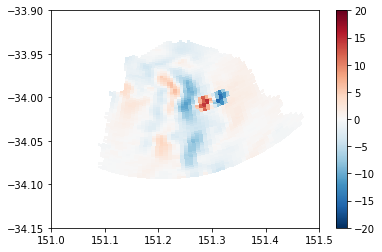

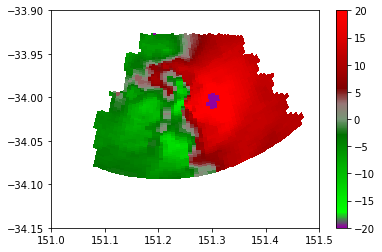

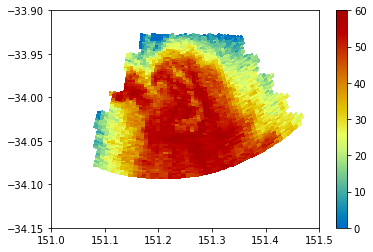

In [6]:
s = 8
obj = 2
polar_x = radar1.get_gate_lat_lon_alt(s)[1][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_y = radar1.get_gate_lat_lon_alt(s)[0][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_z = radar1.get_gate_lat_lon_alt(s)[2][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_obj = interp(polar_x, polar_y)
print(np.nanmax(np.abs(np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan))))

plt.pcolormesh(polar_x, polar_y, np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan), vmin=-20, vmax=20, cmap=plt.cm.RdBu_r); plt.colorbar()
plt.xlim([151, 151.5]); plt.ylim([-34.15, -33.9])

plt.figure()
plt.pcolormesh(polar_x, polar_y, np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "velocity")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan), vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel); plt.colorbar()
plt.xlim([151, 151.5]); plt.ylim([-34.15, -33.9])

plt.figure()
plt.pcolormesh(polar_x, polar_y, np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "reflectivity")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan), vmin=0, vmax=60, cmap=pyart.graph.cm_colorblind.HomeyerRainbow); plt.colorbar()
plt.xlim([151, 151.5]); plt.ylim([-34.15, -33.9])

In [26]:
s=8
obj=2
polar_x = radar1.get_gate_lat_lon_alt(s)[1][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_y = radar1.get_gate_lat_lon_alt(s)[0][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_z = radar1.get_gate_lat_lon_alt(s)[2][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_obj = interp(polar_x, polar_y)

In [32]:
#np.nanmax(
#    np.abs(
np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                            radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                            np.nan)
#    )
#)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)